# Machine Learning Pipeline for Network Intrusion Detection

This notebook implements a comprehensive machine learning pipeline for network intrusion detection using the CSE-CIC-IDS2018 dataset. The pipeline includes data preprocessing, exploratory data analysis, feature engineering, and various machine learning models for classification.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Preprocessing and Transformation](#preprocessing)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Feature Engineering](#feature_engineering)
5. [Machine Learning Phase](#ml_phase)
6. [Model Evaluation](#evaluation)
7. [Model Usage](#usage)

<a id="setup"></a>
## 1. Setup and Imports

First, we'll import all the necessary libraries for our machine learning pipeline.

In [1]:
# Basic data manipulation libraries
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_curve, auc, 
    silhouette_score, mean_squared_error, r2_score
)

# Advanced ML models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Neural Networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

2025-06-22 15:56:44.113593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750607804.394898      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750607804.468909      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="preprocessing"></a>
## 2. Data Preprocessing and Transformation

In this section, we'll load the dataset, inspect it, clean it, and prepare it for analysis and modeling.

### 2.1 Load Dataset from CSV Files

In [2]:
class DataProcessor:
    def __init__(self, data_path=None):
        self.data_path = data_path or '/kaggle/input/cic-ids2018/' 
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.non_numeric_cols = ['Timestamp', 'Flow ID', 'Source IP', 'Destination IP',
                                'Source Port', 'Destination Port', 'Protocol']
        self.valid_labels = {
            'BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'FTP-Patator',
            'DoS GoldenEye', 'DoS Slowloris', 'SSH-Patator', 'Web Attack',
            'Bot', 'Brute Force-Web', 'Brute Force-XSS', 'SQL Injection',
            'Infiltration', 'DDOS-LOIC-HTTP', 'DDOS-HOIC', 'SSH-Bruteforce',
            'FTP-Bruteforce', 'DDoS-LOIC-UDP'
        }
        self.label_aliases = {
            'benign': 'BENIGN', 'benign': 'BENIGN', 'BENIGN': 'BENIGN',  
            'ddos': 'DDoS',
            'portscan': 'PortScan',
            'ftp-patator': 'FTP-Patator',
            'dos attacks-hulk': 'DoS Hulk',
            'dos attacks-slowloris': 'DoS Slowloris',
            'brute force -web': 'Brute Force-Web',
            'ddos attack-loic-http': 'DDOS-LOIC-HTTP',
            'ssh-bruteforce': 'SSH-Bruteforce',
            'bot': 'Bot',
            'sql injection': 'SQL Injection',
            'infilteration': 'Infiltration'
        }

    def load_data(self):
        files = [f for f in os.listdir(self.data_path) if f.endswith('.csv')][:5]
        dfs = []
        chunk_size = 100000  # adjusted to handle memory constraints
        
        for file in tqdm(files, desc="Loading files"):
            try:
                # Read in chunks to avoid memory issues
                chunks = []
                for chunk in pd.read_csv(os.path.join(self.data_path, file),
                                       dtype={'Flow ID': str, 'Source IP': str, 'Destination IP': str,
                                              'Source Port': 'category', 'Destination Port': 'category',
                                              'Protocol': 'category'},
                                       chunksize=chunk_size, low_memory=False):
                    # Process each chunk
                    chunk.columns = chunk.columns.str.strip().str.replace(' ', '').str.title()
                    label_col = next((col for col in chunk.columns if 'label' in col.lower()), None)
                    
                    if label_col:
                        chunk[label_col] = chunk[label_col].astype(str).str.strip().str.upper()
                        chunk[label_col] = chunk[label_col].replace(
                            {k.upper(): v for k, v in self.label_aliases.items()}
                        )
                        valid_mask = chunk[label_col].isin(self.valid_labels)
                        if valid_mask.any():
                            chunk = chunk[valid_mask].copy()
                            chunk = chunk.rename(columns={label_col: 'Label'})
                            chunks.append(chunk)
                
                if chunks:
                    df = pd.concat(chunks, ignore_index=True)
                    dfs.append(df)
                else:
                    print(f"Skipping {file} - no valid data")

            except Exception as e:
                print(f"Skipping {file} due to error: {str(e)}")
                continue

        if not dfs:
            raise ValueError("No valid data files found. Check dataset contents.")

        full_df = pd.concat(dfs, axis=0)
        return full_df
    
    def preprocess(self, df):
        df['Timestamp'] = pd.to_datetime(
            df['Timestamp'], 
            format='%d/%m/%Y %H:%M:%S',
            dayfirst=True,
            errors='coerce'
        )
        df = df.dropna(subset=['Timestamp'])
        df['TimeWindow'] = (df['Timestamp'].dt.minute // 5) * 5
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col != 'Label']        
        time_features = df.groupby('TimeWindow')[numeric_cols].agg(['mean', 'std']).reset_index()
        time_features.columns = ['_'.join(col).strip() if col[1] else col[0] 
                                for col in time_features.columns.values]
        time_features = time_features.rename(columns={'TimeWindow_': 'TimeWindow'})
        df = df.drop(columns=self.non_numeric_cols, errors='ignore')
        for col in df.columns:
            if col != 'Label':
                df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(axis=1, how='all')
        df = df.dropna()
        df = df.drop_duplicates()
        df = pd.merge(df, time_features, on='TimeWindow', how='left')        
        if df.select_dtypes(include=np.number).replace([np.inf, -np.inf], np.nan).isna().any().any():
            raise ValueError("Data contains invalid values after preprocessing")
        valid_labels = df['Label'].unique()
        if 'BENIGN' not in valid_labels:
            raise ValueError("Dataset missing BENIGN label")

        df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

        # Feature scaling
        features = df.drop('Label', axis=1)
        labels = df['Label']
        scaled_features = self.scaler.fit_transform(features)

        return scaled_features, labels

def load_dataset(data_path='/kaggle/input/ids-intrusion-csv'):
    """
    Load CSV files from the specified directory using the DataProcessor class
    to handle memory constraints.
    
    Args:
        data_path (str): Path to the directory containing CSV files
        
    Returns:
        pd.DataFrame: Combined DataFrame from all CSV files
    """
    processor = DataProcessor(data_path)
    try:
        df = processor.load_data()
        print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        print("Using sample data for demonstration purposes...")
        # Create a sample dataset for demonstration
        return create_sample_dataset(1000)
        
def create_sample_dataset(n_samples=1000):
    """
    Create a sample dataset for demonstration purposes.
    
    Args:
        n_samples (int): Number of samples to generate
        
    Returns:
        pd.DataFrame: Sample DataFrame
    """
    np.random.seed(42)
    
    # Create sample features
    sample_data = {
        'Flow Duration': np.random.randint(1, 100000, n_samples),
        'Total Fwd Packets': np.random.randint(1, 100, n_samples),
        'Total Backward Packets': np.random.randint(1, 100, n_samples),
        'Total Length of Fwd Packets': np.random.randint(1, 10000, n_samples),
        'Total Length of Bwd Packets': np.random.randint(1, 10000, n_samples),
        'Fwd Packet Length Max': np.random.randint(1, 1500, n_samples),
        'Fwd Packet Length Min': np.random.randint(0, 100, n_samples),
        'Fwd Packet Length Mean': np.random.uniform(10, 500, n_samples),
        'Bwd Packet Length Max': np.random.randint(1, 1500, n_samples),
        'Bwd Packet Length Min': np.random.randint(0, 100, n_samples),
        'Bwd Packet Length Mean': np.random.uniform(10, 500, n_samples),
        'Flow Bytes/s': np.random.uniform(0, 10000, n_samples),
        'Flow Packets/s': np.random.uniform(0, 1000, n_samples),
        'Flow IAT Mean': np.random.uniform(0, 1000, n_samples),
        'Flow IAT Std': np.random.uniform(0, 500, n_samples),
        'Flow IAT Max': np.random.uniform(0, 2000, n_samples),
        'Flow IAT Min': np.random.uniform(0, 100, n_samples),
        'Fwd Header Length.1': np.random.randint(20, 100, n_samples),  # Duplicate column
        'Fwd Header Length': np.random.randint(20, 100, n_samples),
        'Protocol': np.random.choice(['TCP', 'UDP', 'ICMP'], n_samples),
        'Destination Port': np.random.choice([80, 443, 22, 53, 8080], n_samples),
        'Label': np.random.choice(['BENIGN', 'DoS Hulk', 'PortScan', 'Brute Force-Web', 'Web Attack'], n_samples, 
                                 p=[0.7, 0.1, 0.1, 0.05, 0.05])
    }
    
    # Create DataFrame
    df = pd.DataFrame(sample_data)
    print(f"Created sample dataset: {df.shape[0]} rows, {df.shape[1]} columns")
    
    return df

# Load the dataset
try:
    df = load_dataset()
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Using sample data for demonstration purposes...")
    # Create a sample dataset for demonstration
    df = create_sample_dataset(1000)

Loading files: 100%|██████████| 5/5 [01:26<00:00, 17.28s/it]


Loaded dataset: 3220755 rows, 80 columns


### 2.2 Inspect Data Types and Count Non-Null Values

In [3]:
# Display basic information about the dataset
print("Dataset Information:")
df.info()

# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
df.head()

# Count non-null values for each column
print("\nNon-null value counts:")
non_null_counts = df.count()
print(non_null_counts)

# Calculate percentage of non-null values
non_null_percentage = (non_null_counts / len(df)) * 100
print("\nPercentage of non-null values:")
print(non_null_percentage)

# Display data types
print("\nData types:")
print(df.dtypes)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 3220755 entries, 0 to 360832
Data columns (total 80 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Dstport         object
 1   Protocol        object
 2   Timestamp       object
 3   Flowduration    object
 4   Totfwdpkts      object
 5   Totbwdpkts      object
 6   Totlenfwdpkts   object
 7   Totlenbwdpkts   object
 8   Fwdpktlenmax    object
 9   Fwdpktlenmin    object
 10  Fwdpktlenmean   object
 11  Fwdpktlenstd    object
 12  Bwdpktlenmax    object
 13  Bwdpktlenmin    object
 14  Bwdpktlenmean   object
 15  Bwdpktlenstd    object
 16  Flowbyts/S      object
 17  Flowpkts/S      object
 18  Flowiatmean     object
 19  Flowiatstd      object
 20  Flowiatmax      object
 21  Flowiatmin      object
 22  Fwdiattot       object
 23  Fwdiatmean      object
 24  Fwdiatstd       object
 25  Fwdiatmax       object
 26  Fwdiatmin       object
 27  Bwdiattot       object
 28  Bwdiatmean      object
 29 

### 2.3 Normalize Column Names

In [4]:
# Function to normalize column names
def normalize_column_names(df):
    """
    Normalize column names by removing leading/trailing whitespace,
    replacing spaces with underscores, and converting to lowercase.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with normalized column names
    """
    # Store original column names for reference
    original_columns = df.columns.tolist()
    
    # Normalize column names
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
    
    # Print mapping of original to normalized column names
    print("Column name mapping:")
    for orig, norm in zip(original_columns, df.columns):
        if orig != norm:
            print(f"  {orig} -> {norm}")
    
    return df

# Normalize column names
df = normalize_column_names(df)

# Display the first few rows with normalized column names
df.head()

Column name mapping:
  Dstport -> dstport
  Protocol -> protocol
  Timestamp -> timestamp
  Flowduration -> flowduration
  Totfwdpkts -> totfwdpkts
  Totbwdpkts -> totbwdpkts
  Totlenfwdpkts -> totlenfwdpkts
  Totlenbwdpkts -> totlenbwdpkts
  Fwdpktlenmax -> fwdpktlenmax
  Fwdpktlenmin -> fwdpktlenmin
  Fwdpktlenmean -> fwdpktlenmean
  Fwdpktlenstd -> fwdpktlenstd
  Bwdpktlenmax -> bwdpktlenmax
  Bwdpktlenmin -> bwdpktlenmin
  Bwdpktlenmean -> bwdpktlenmean
  Bwdpktlenstd -> bwdpktlenstd
  Flowbyts/S -> flowbyts/s
  Flowpkts/S -> flowpkts/s
  Flowiatmean -> flowiatmean
  Flowiatstd -> flowiatstd
  Flowiatmax -> flowiatmax
  Flowiatmin -> flowiatmin
  Fwdiattot -> fwdiattot
  Fwdiatmean -> fwdiatmean
  Fwdiatstd -> fwdiatstd
  Fwdiatmax -> fwdiatmax
  Fwdiatmin -> fwdiatmin
  Bwdiattot -> bwdiattot
  Bwdiatmean -> bwdiatmean
  Bwdiatstd -> bwdiatstd
  Bwdiatmax -> bwdiatmax
  Bwdiatmin -> bwdiatmin
  Fwdpshflags -> fwdpshflags
  Bwdpshflags -> bwdpshflags
  Fwdurgflags -> fwdurgflags
  

,dstport,protocol,timestamp,flowduration,totfwdpkts,totbwdpkts,totlenfwdpkts,totlenbwdpkts,fwdpktlenmax,fwdpktlenmin,...,fwdsegsizemin,activemean,activestd,activemax,activemin,idlemean,idlestd,idlemax,idlemin,label
0,443,6,28/02/2018 08:22:13,94658,6,7,708,3718,387,0,...,20,0,0,0,0,0,0,0,0,BENIGN
1,443,6,28/02/2018 08:22:13,206,2,0,0,0,0,0,...,20,0,0,0,0,0,0,0,0,BENIGN
2,445,6,28/02/2018 08:22:15,165505,3,1,0,0,0,0,...,20,0,0,0,0,0,0,0,0,BENIGN
3,443,6,28/02/2018 08:22:16,102429,6,7,708,3718,387,0,...,20,0,0,0,0,0,0,0,0,BENIGN
4,443,6,28/02/2018 08:22:16,167,2,0,0,0,0,0,...,20,0,0,0,0,0,0,0,0,BENIGN


### 2.4 Identify and Remove Duplicate Columns

In [5]:
# Function to identify and remove duplicate columns
def remove_duplicate_columns(df):
    """
    Identify and remove duplicate columns from the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with duplicate columns removed
    """
    # Get list of all columns
    columns = df.columns.tolist()
    
    # Initialize list to store duplicate columns
    duplicate_columns = []
    
    # Check for columns ending with '.1', '.2', etc.
    for col in columns:
        if col.endswith(('.1', '.2', '.3', '.4', '.5')):
            base_col = col.rsplit('.', 1)[0]
            if base_col in columns:
                # Check if the columns are actually duplicates
                if df[col].equals(df[base_col]):
                    duplicate_columns.append(col)
                    print(f"Found duplicate column: {col} (duplicate of {base_col})")
    
    # Remove duplicate columns
    if duplicate_columns:
        df = df.drop(columns=duplicate_columns)
        print(f"Removed {len(duplicate_columns)} duplicate columns")
    else:
        print("No duplicate columns found")
    
    return df

# Remove duplicate columns
df = remove_duplicate_columns(df)

# Display the shape of the DataFrame after removing duplicate columns
print(f"DataFrame shape after removing duplicate columns: {df.shape}")

No duplicate columns found
DataFrame shape after removing duplicate columns: (3220755, 80)


### 2.5 Convert Categorical Features using Label Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_features(df, verbose=False):
    """
    Encode categorical features using Label Encoding.

    Args:
        df (pd.DataFrame): Input DataFrame
        verbose (bool): If True, prints detailed encoding information

    Returns:
        pd.DataFrame: DataFrame with encoded categorical features
        dict: Dictionary mapping column names to their respective label encoders
    """
    df_encoded = df.copy()
    label_encoders = {}

    # Identify categorical columns (excluding the target variable)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'label' in categorical_columns:
        categorical_columns.remove('label')

    if verbose:
        print(f"Found {len(categorical_columns)} categorical columns: {categorical_columns}")

    # Encode each categorical column
    for col in categorical_columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        if verbose:
            print(f"Encoded '{col}': {dict(zip(le.classes_, le.transform(le.classes_)))}")

    # Handle the target variable separately
    if 'label' in df.columns:
        le = LabelEncoder()
        df_encoded['label'] = le.fit_transform(df['label'].astype(str))
        label_encoders['label'] = le
        if verbose:
            print(f"Encoded 'label': {dict(zip(le.classes_, le.transform(le.classes_)))}")

    return df_encoded, label_encoders

df_encoded, label_encoders = encode_categorical_features(df, verbose=False)

### 2.6 Convert All Data Types to Float

In [7]:
# Function to convert all data types to float
def convert_to_float(df):
    """
    Convert all columns (except the target variable) to float.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with all columns converted to float
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_float = df.copy()
    
    # Get list of all columns except the target variable
    columns = df.columns.tolist()
    if 'label' in columns:
        columns.remove('label')
    
    # Convert each column to float
    for col in columns:
        df_float[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    
    return df_float

# Convert all data types to float
df_float = convert_to_float(df_encoded)

# Display the data types after conversion
print("Data types after conversion:")
print(df_float.dtypes)

Data types after conversion:
dstport         float64
protocol        float64
timestamp       float64
flowduration    float64
totfwdpkts      float64
                 ...   
idlemean        float64
idlestd         float64
idlemax         float64
idlemin         float64
label             int64
Length: 80, dtype: object


### 2.7 Replace Infinite Values with NaN

In [8]:
# Function to replace infinite values with NaN
def replace_inf_with_nan(df):
    """
    Replace infinite values with NaN in the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with infinite values replaced with NaN
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_no_inf = df.copy()
    
    # Replace infinite values with NaN
    df_no_inf = df_no_inf.replace([np.inf, -np.inf], np.nan)
    
    # Count NaN values after replacement
    nan_counts = df_no_inf.isna().sum()
    print("NaN counts after replacing infinite values:")
    print(nan_counts[nan_counts > 0])
    
    return df_no_inf

# Replace infinite values with NaN
df_no_inf = replace_inf_with_nan(df_float)

NaN counts after replacing infinite values:
Series([], dtype: int64)


### 2.8 Handle Missing Values (NaN) by Imputing with the Column Mean

In [9]:
# Function to impute missing values with column mean
def impute_missing_values(df):
    """
    Impute missing values (NaN) with the column mean.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with missing values imputed
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_imputed = df.copy()
    
    # Get list of all columns except the target variable
    columns = df.columns.tolist()
    if 'label' in columns:
        columns.remove('label')
    
    # Impute missing values with column mean
    for col in columns:
        if df_imputed[col].isna().any():
            mean_value = df_imputed[col].mean()
            df_imputed[col] = df_imputed[col].fillna(mean_value)
            print(f"Imputed {df_imputed[col].isna().sum()} missing values in {col} with mean: {mean_value:.4f}")
    
    # Verify that there are no more missing values
    nan_counts = df_imputed.isna().sum()
    if nan_counts.sum() > 0:
        print("Warning: There are still missing values in the DataFrame")
        print(nan_counts[nan_counts > 0])
    else:
        print("All missing values have been imputed")
    
    return df_imputed

# Impute missing values with column mean
df_imputed = impute_missing_values(df_no_inf)

All missing values have been imputed


### 2.9 Replace Nonsensical Negative Values with the Median

In [10]:
# Function to replace nonsensical negative values with the median
def replace_negative_values(df):
    """
    Replace nonsensical negative values in specific columns with the median.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with nonsensical negative values replaced
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_no_neg = df.copy()
    
    # List of columns that should not have negative values
    # These are typically columns representing counts, durations, lengths, etc.
    non_negative_columns = [
        col for col in df.columns if any(keyword in col.lower() for keyword in 
                                        ['duration', 'length', 'packets', 'bytes', 'count', 'min', 'max', 'mean'])
    ]
    
    print(f"Found {len(non_negative_columns)} columns that should not have negative values")
    
    # Replace negative values with the median in each column
    for col in non_negative_columns:
        if col in df_no_neg.columns and (df_no_neg[col] < 0).any():
            neg_count = (df_no_neg[col] < 0).sum()
            median_value = df_no_neg[df_no_neg[col] >= 0][col].median()
            df_no_neg.loc[df_no_neg[col] < 0, col] = median_value
            print(f"Replaced {neg_count} negative values in {col} with median: {median_value:.4f}")
    
    return df_no_neg

# Replace nonsensical negative values with the median
df_no_neg = replace_negative_values(df_imputed)

Found 27 columns that should not have negative values


### 2.10 Detect and Remove Outliers using Isolation Forest

In [11]:
# Function to detect and remove outliers using Isolation Forest
def remove_outliers(df, contamination=0.05):
    """
    Detect and remove outliers using the Isolation Forest algorithm.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        contamination (float): The proportion of outliers in the dataset
        
    Returns:
        pd.DataFrame: DataFrame with outliers removed
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_no_outliers = df.copy()
    
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Initialize and fit the Isolation Forest model
    isolation_forest = IsolationForest(contamination=contamination, random_state=RANDOM_STATE)
    outlier_pred = isolation_forest.fit_predict(X)
    
    # Count outliers
    outlier_count = (outlier_pred == -1).sum()
    print(f"Detected {outlier_count} outliers ({outlier_count/len(df)*100:.2f}% of the dataset)")
    
    # Remove outliers
    df_no_outliers = df_no_outliers[outlier_pred == 1]
    print(f"DataFrame shape after removing outliers: {df_no_outliers.shape}")
    
    return df_no_outliers

# Detect and remove outliers
df_no_outliers = remove_outliers(df_no_neg)

Detected 161038 outliers (5.00% of the dataset)
DataFrame shape after removing outliers: (3059717, 80)


### 2.11 Scale All Numerical Features using StandardScaler

In [12]:
# Function to scale numerical features
def scale_features(df):
    """
    Scale all numerical features using StandardScaler.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with scaled features
        StandardScaler: Fitted scaler object
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_scaled = df.copy()
    
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Initialize and fit the StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create a new DataFrame with scaled features
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Add the target variable back to the DataFrame
    if 'label' in df.columns:
        df_scaled['label'] = df['label'].values
    
    print(f"Features scaled using StandardScaler")
    
    return df_scaled, scaler

# Scale numerical features
df_scaled, scaler = scale_features(df_no_outliers)

# Display the first few rows of the scaled DataFrame
df_scaled.head()

Features scaled using StandardScaler


,dstport,protocol,timestamp,flowduration,totfwdpkts,totbwdpkts,totlenfwdpkts,totlenbwdpkts,fwdpktlenmax,fwdpktlenmin,...,fwdsegsizemin,activemean,activestd,activemax,activemin,idlemean,idlestd,idlemax,idlemin,label
0,-0.799683,0.532357,1.227395,1.877659,1.320839,2.522953,0.880685,0.825370,0.146109,-0.517876,...,-0.841128,-0.170293,-0.131612,-0.166412,-0.158032,-0.229183,-0.150818,-0.219082,-0.223216,0
1,-0.799683,0.532357,1.227395,-0.625812,-0.428172,-0.746721,-1.165672,-1.004642,-1.258914,-0.517876,...,-0.841128,-0.170293,-0.131612,-0.166412,-0.158032,-0.229183,-0.150818,-0.219082,-0.223216,0
2,-0.785147,0.532357,1.227495,-0.791930,0.268499,-0.743858,-1.165672,-1.004642,-1.258914,-0.517876,...,-0.841128,-0.170293,-0.131612,-0.166412,-0.158032,-0.229183,-0.150818,-0.219082,-0.223216,0
3,-0.799683,0.532357,1.227544,-1.487579,1.320839,2.522953,0.880685,0.825370,0.146109,-0.517876,...,-0.841128,-0.170293,-0.131612,-0.166412,-0.158032,-0.229183,-0.150818,-0.219082,-0.223216,0
4,-0.799683,0.532357,1.227544,-0.779006,-0.428172,-0.746721,-1.165672,-1.004642,-1.258914,-0.517876,...,-0.841128,-0.170293,-0.131612,-0.166412,-0.158032,-0.229183,-0.150818,-0.219082,-0.223216,0


### 2.12 Summary of Data Preprocessing

In [13]:
# Display summary of data preprocessing steps
print("Summary of Data Preprocessing Steps:")
print(f"1. Original DataFrame shape: {df.shape}")
print(f"2. After removing duplicate columns: {df_encoded.shape}")
print(f"3. After handling missing values: {df_imputed.shape}")
print(f"4. After removing outliers: {df_no_outliers.shape}")
print(f"5. Final DataFrame shape: {df_scaled.shape}")

# Display class distribution
if 'label' in df_scaled.columns:
    print("\nClass Distribution:")
    class_counts = df_scaled['label'].value_counts()
    class_percentages = class_counts / len(df_scaled) * 100
    
    # Create a DataFrame to display class distribution
    class_distribution = pd.DataFrame({
        'Count': class_counts,
        'Percentage': class_percentages
    })
    
    # Map numeric labels back to original class names
    if 'label' in label_encoders:
        class_distribution.index = [label_encoders['label'].inverse_transform([i])[0] for i in class_distribution.index]
    
    print(class_distribution)

Summary of Data Preprocessing Steps:
1. Original DataFrame shape: (3220755, 80)
2. After removing duplicate columns: (3220755, 80)
3. After handling missing values: (3220755, 80)
4. After removing outliers: (3059717, 80)
5. Final DataFrame shape: (3059717, 80)

Class Distribution:
                 Count  Percentage
BENIGN         2442703   79.834279
DoS Hulk        460297   15.043777
Infiltration    147073    4.806752
DoS Slowloris     9644    0.315193


<a id="eda"></a>
## 3. Exploratory Data Analysis (EDA)

In this section, we'll perform exploratory data analysis to understand the dataset better.

### 3.1 Descriptive Statistics

In [14]:
# Function to compute descriptive statistics
def compute_descriptive_statistics(df):
    """
    Compute descriptive statistics for the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        
    Returns:
        pd.DataFrame: DataFrame with descriptive statistics
    """
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Compute descriptive statistics
    stats = X.describe(percentiles=[0.25, 0.5, 0.75])
    
    # Add mode to the statistics
    mode = X.mode().iloc[0]
    stats.loc['mode'] = mode
    
    return stats

# Compute descriptive statistics
stats = compute_descriptive_statistics(df_no_outliers)

# Display descriptive statistics
print("Descriptive Statistics:")
stats

Descriptive Statistics:


,dstport,protocol,timestamp,flowduration,totfwdpkts,totbwdpkts,totlenfwdpkts,totlenbwdpkts,fwdpktlenmax,fwdpktlenmin,...,fwdactdatapkts,fwdsegsizemin,activemean,activestd,activemax,activemin,idlemean,idlestd,idlemax,idlemin
count,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,...,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06,3.059717e+06
mean,2.326600e+04,1.757792e+00,5.984193e+04,4.775542e+05,3.497733e+02,2.608075e+02,4.395286e+03,9.123519e+03,7.060557e+02,1.984688e+01,...,1.951618e+01,3.924493e+00,3.930599e+03,1.893186e+03,3.351974e+03,1.579606e+03,7.880556e+03,2.727637e+03,5.839559e+03,6.588628e+03
std,9.631318e+03,4.549732e-01,2.014353e+04,3.132124e+05,2.727256e+02,3.492704e+02,3.770603e+03,9.081363e+03,5.608450e+02,3.832362e+01,...,5.446315e+01,3.476872e+00,2.308142e+04,1.438464e+04,2.014259e+04,9.995475e+03,3.438546e+04,1.808561e+04,2.665469e+04,2.951686e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.570400e+04,2.000000e+00,5.207900e+04,2.286210e+05,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.280900e+04,2.000000e+00,6.603200e+04,3.956520e+05,2.330000e+02,1.000000e+00,4.822000e+03,6.773000e+03,7.800000e+02,0.000000e+00,...,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,3.240200e+04,2.000000e+00,6.684200e+04,7.351910e+05,6.420000e+02,5.230000e+02,9.019000e+03,1.560400e+04,1.402000e+03,0.000000e+00,...,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,3.741900e+04,2.000000e+00,1.006500e+05,1.076670e+06,8.710000e+02,1.366000e+03,9.291000e+03,3.009200e+04,1.471000e+03,1.970000e+02,...,2.750000e+02,1.000000e+01,2.292710e+05,1.780690e+05,2.003510e+05,1.143920e+05,2.571030e+05,1.889800e+05,1.991330e+05,2.204880e+05
mode,3.654500e+04,2.000000e+00,6.597300e+04,2.740370e+05,6.420000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00


### 3.2 Visualize Descriptive Statistics

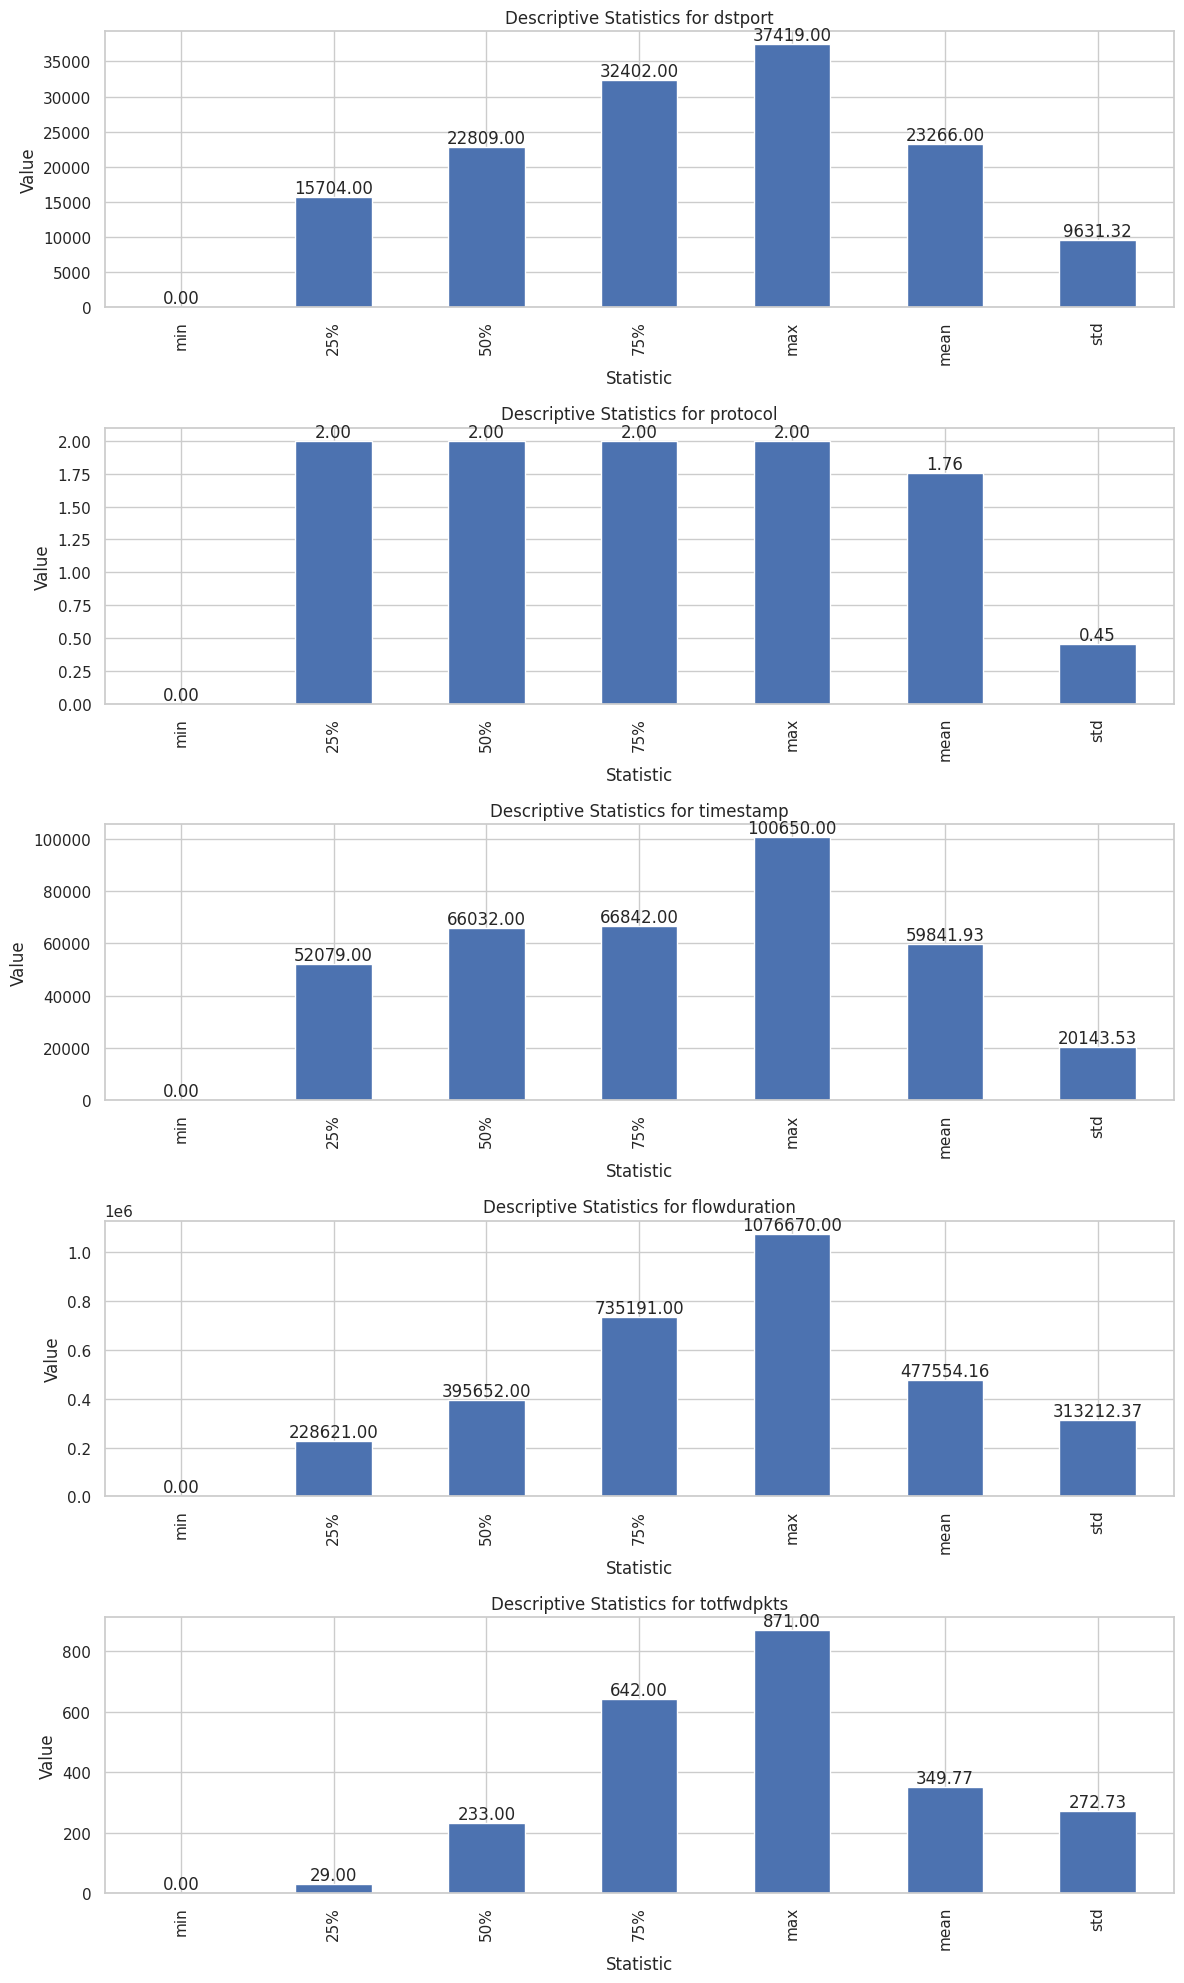

In [15]:
# Function to visualize descriptive statistics
def visualize_descriptive_statistics(stats):
    """
    Visualize descriptive statistics using bar plots.
    
    Args:
        stats (pd.DataFrame): DataFrame with descriptive statistics
    """
    # Select a subset of columns for visualization
    selected_columns = stats.columns[:5]  # Select first 5 columns
    
    # Select statistics to visualize
    selected_stats = ['min', '25%', '50%', '75%', 'max', 'mean', 'std']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(selected_columns), 1, figsize=(12, 4 * len(selected_columns)))
    
    # Plot each column's statistics
    for i, col in enumerate(selected_columns):
        ax = axes[i] if len(selected_columns) > 1 else axes
        
        # Extract statistics for the column
        col_stats = stats.loc[selected_stats, col]
        
        # Create bar plot
        col_stats.plot(kind='bar', ax=ax)
        
        # Set title and labels
        ax.set_title(f'Descriptive Statistics for {col}')
        ax.set_ylabel('Value')
        ax.set_xlabel('Statistic')
        
        # Add value labels on top of bars
        for j, v in enumerate(col_stats):
            ax.text(j, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Visualize descriptive statistics
visualize_descriptive_statistics(stats)

### 3.3 Distribution Analysis

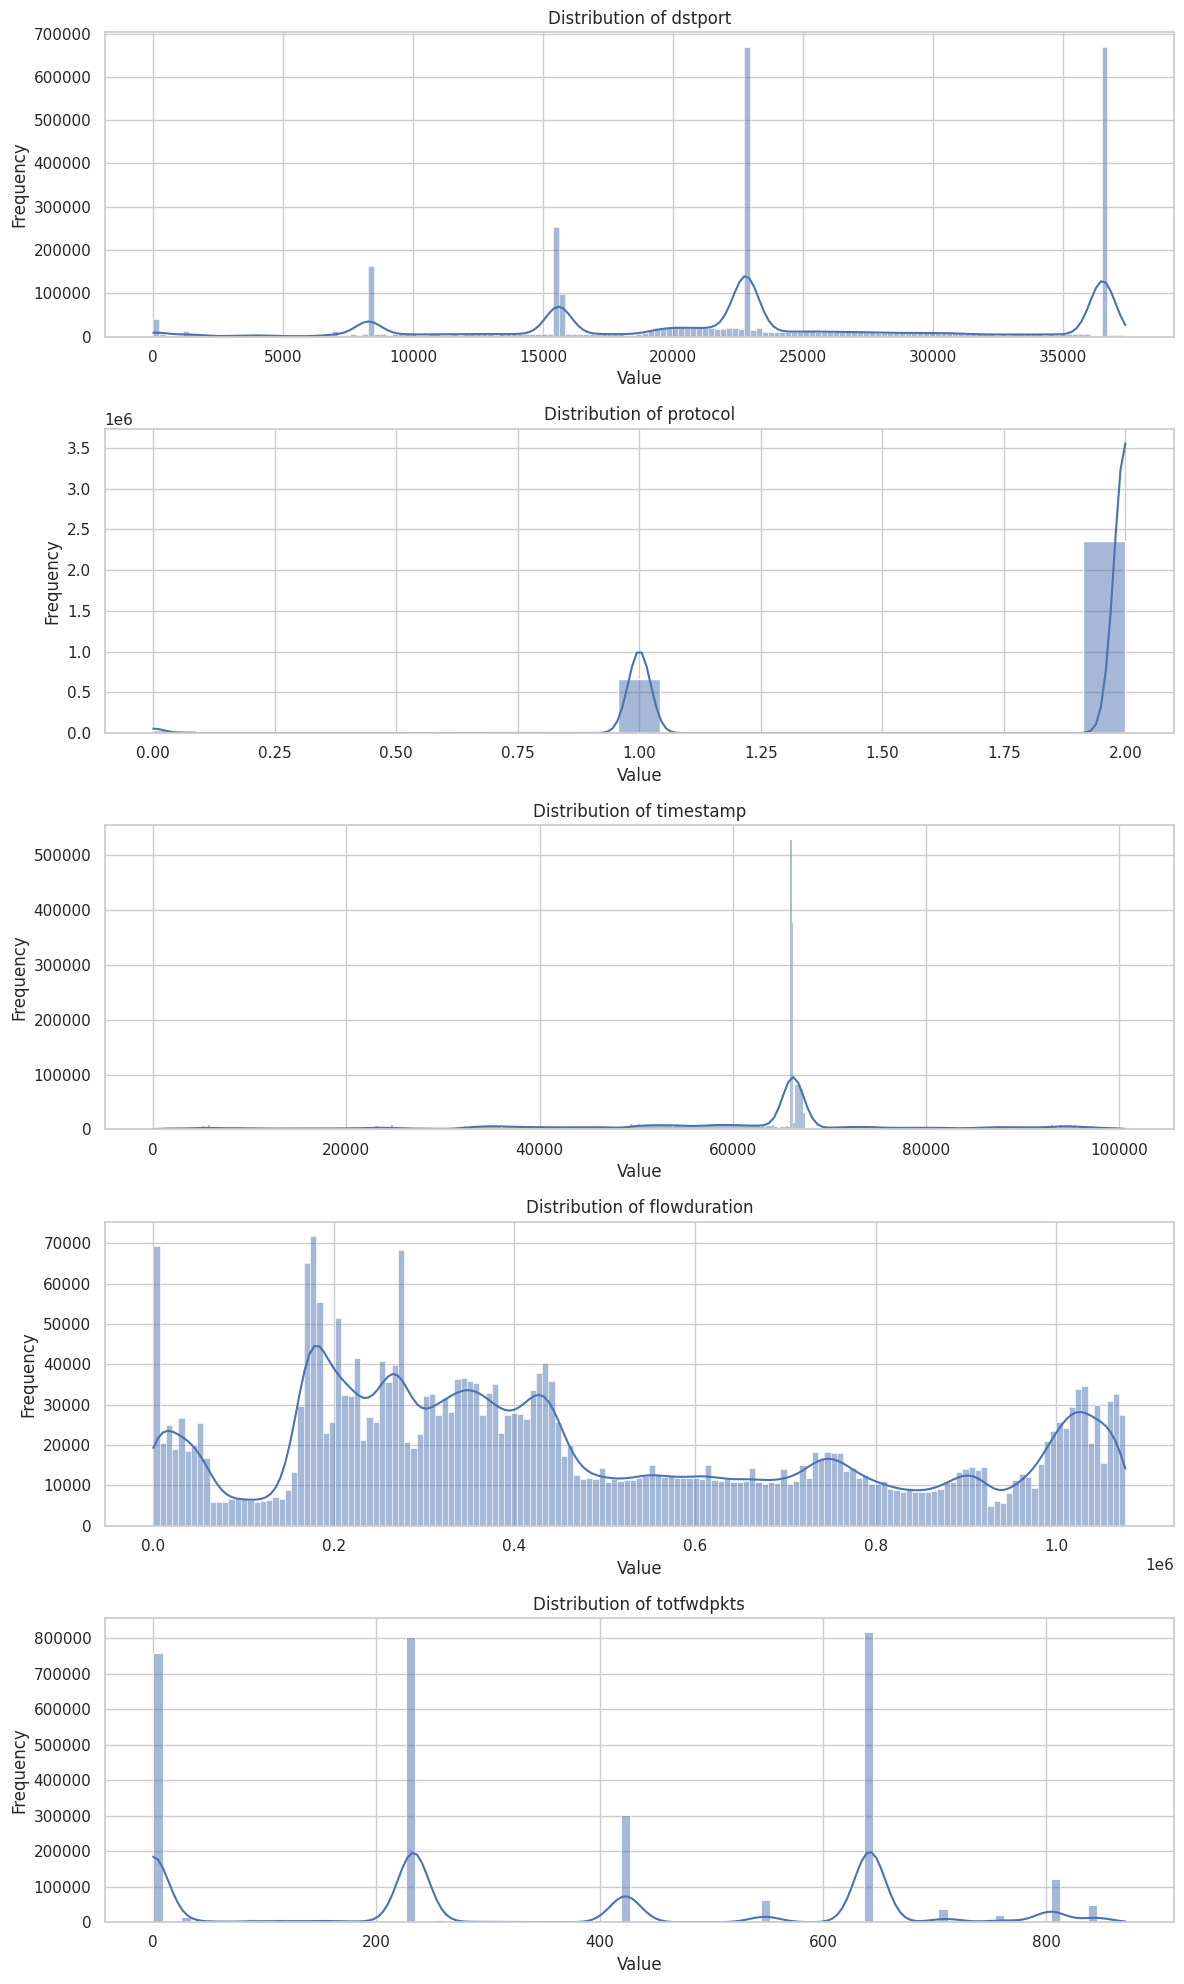

In [16]:
# Function to plot histograms for selected features
def plot_histograms(df, n_cols=5):
    """
    Plot histograms for selected features.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        n_cols (int): Number of columns to visualize
    """
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Select a subset of columns for visualization
    selected_columns = X.columns[:n_cols]  # Select first n_cols columns
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4 * n_cols))
    
    # Plot histogram for each column
    for i, col in enumerate(selected_columns):
        ax = axes[i] if n_cols > 1 else axes
        
        # Plot histogram
        sns.histplot(df[col], kde=True, ax=ax)
        
        # Set title and labels
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot histograms for selected features
plot_histograms(df_no_outliers)

### 3.4 Visualize Different Distributions

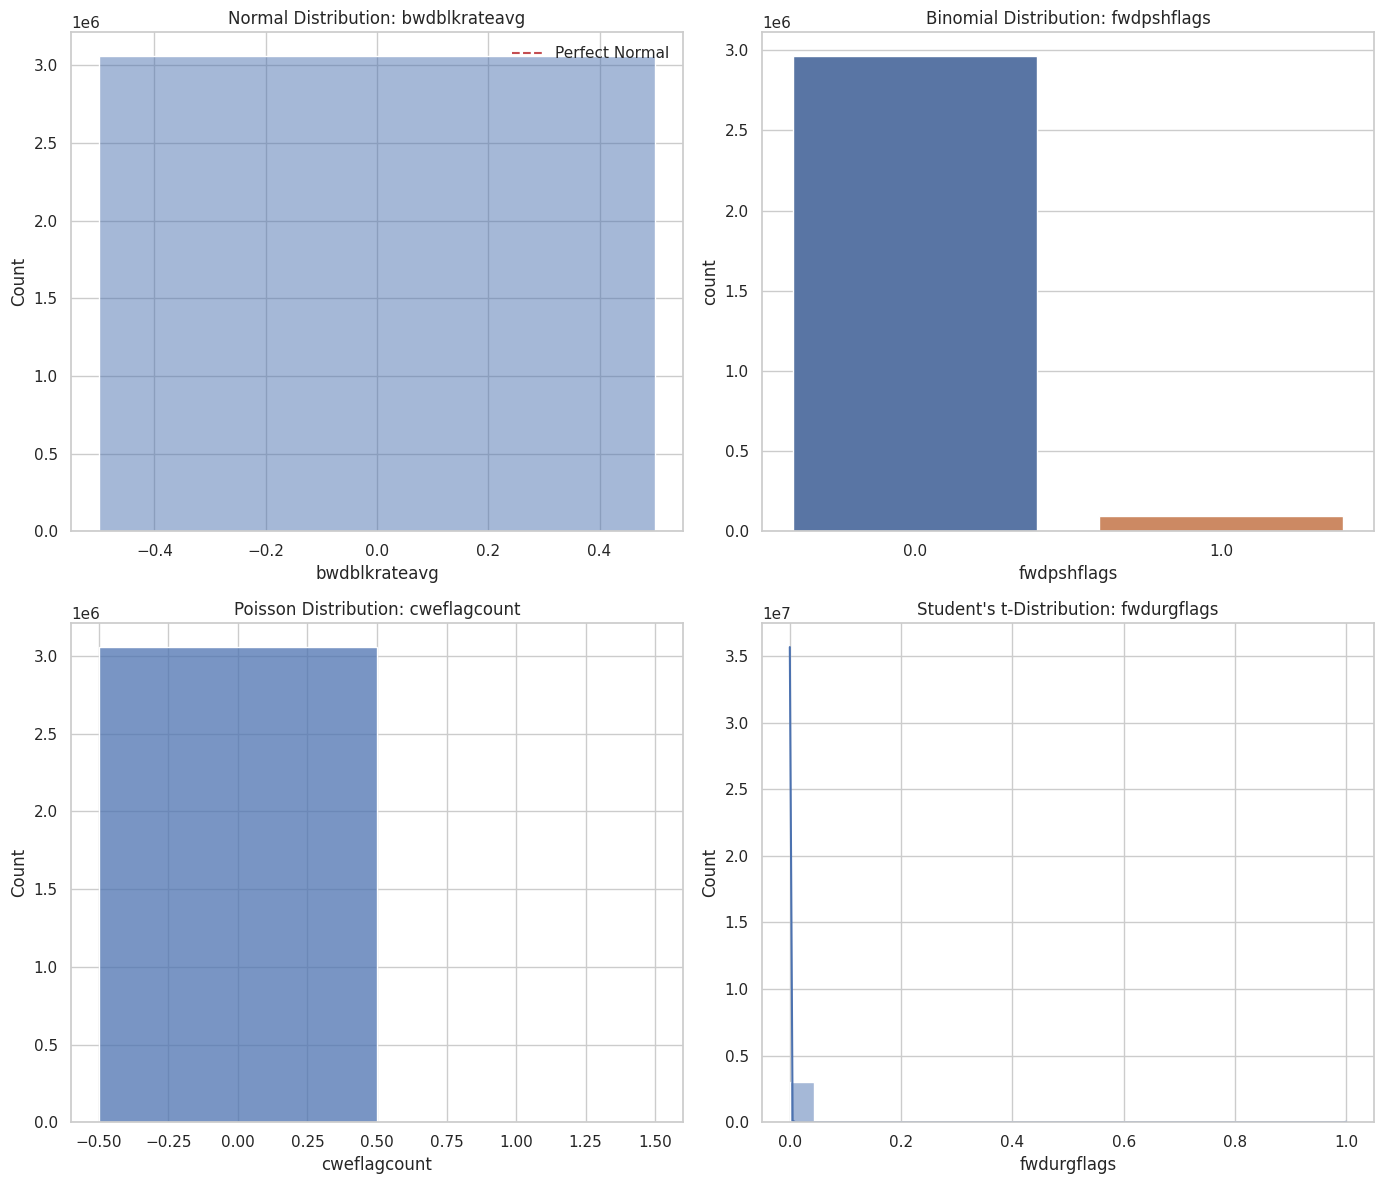

In [17]:
# Function to visualize different distributions
def visualize_distributions(df):
    """
    Visualize and analyze different distributions in the dataset.
    
    Args:
        df (pd.DataFrame): Input DataFrame
    """
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Normal Distribution
    # Find a column that might follow a normal distribution (using skewness close to 0)
    skewness = X.skew().abs()
    normal_col = skewness.sort_values().index[0]
    
    sns.histplot(df[normal_col], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'Normal Distribution: {normal_col}')
    
    # Add a perfect normal distribution for comparison
    x = np.linspace(df[normal_col].min(), df[normal_col].max(), 100)
    mean = df[normal_col].mean()
    std = df[normal_col].std()
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    axes[0, 0].plot(x, y * len(df) * (df[normal_col].max() - df[normal_col].min()) / 10, 'r--', label='Perfect Normal')
    axes[0, 0].legend()
    
    # 2. Binomial Distribution (e.g., for flag columns)
    # Find a column that might follow a binomial distribution (using unique values count = 2)
    binary_cols = [col for col in X.columns if X[col].nunique() == 2]
    if binary_cols:
        binomial_col = binary_cols[0]
        sns.countplot(x=df[binomial_col], ax=axes[0, 1])
        axes[0, 1].set_title(f'Binomial Distribution: {binomial_col}')
    else:
        axes[0, 1].text(0.5, 0.5, 'No binary columns found', ha='center', va='center')
        axes[0, 1].set_title('Binomial Distribution')
    
    # 3. Poisson Distribution (e.g., for packet counts)
    # Find a column that might follow a Poisson distribution (using columns with 'count' or 'packets' in name)
    poisson_cols = [col for col in X.columns if 'count' in col.lower() or 'packets' in col.lower()]
    if poisson_cols:
        poisson_col = poisson_cols[0]
        sns.histplot(df[poisson_col], kde=False, ax=axes[1, 0], discrete=True)
        axes[1, 0].set_title(f'Poisson Distribution: {poisson_col}')
    else:
        axes[1, 0].text(0.5, 0.5, 'No count/packets columns found', ha='center', va='center')
        axes[1, 0].set_title('Poisson Distribution')
    
    # 4. Student's t-Distribution
    # Use a column with high kurtosis for t-distribution
    kurtosis = X.kurtosis()
    t_col = kurtosis.sort_values(ascending=False).index[0]
    
    sns.histplot(df[t_col], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Student\'s t-Distribution: {t_col}')
    
    plt.tight_layout()
    plt.show()

# Visualize different distributions
visualize_distributions(df_no_outliers)

### 3.5 Correlation and Relationship Analysis

In [ ]:
# Function to create a scatter plot matrix
def create_scatter_plot_matrix(df, n_cols=5):
    """
    Create a scatter plot matrix for selected features.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        n_cols (int): Number of columns to visualize
    """
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Select a subset of columns for visualization
    selected_columns = X.columns[:n_cols]  # Select first n_cols columns
    
    # Create a scatter plot matrix
    sns.pairplot(df[list(selected_columns) + ['label']] if 'label' in df.columns else df[selected_columns], 
                hue='label' if 'label' in df.columns else None)
    plt.suptitle('Scatter Plot Matrix', y=1.02)
    plt.show()

# Create a scatter plot matrix
create_scatter_plot_matrix(df_no_outliers)

In [ ]:
# Function to create a correlation matrix heatmap
def create_correlation_matrix(df):
    """
    Create a correlation matrix heatmap.
    
    Args:
        df (pd.DataFrame): Input DataFrame
    """
    # Get list of all columns including the target variable
    columns = df.columns.tolist()
    
    # Compute correlation matrix
    corr_matrix = df[columns].corr()
    
    # Create a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Correlation Matrix Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Create a correlation matrix heatmap
create_correlation_matrix(df_no_outliers)

In [ ]:
# Function to create a filtered heatmap for high correlations
def create_filtered_heatmap(df, threshold=0.5):
    """
    Create a filtered heatmap for high correlations.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        threshold (float): Correlation threshold
    """
    # Get list of all columns including the target variable
    columns = df.columns.tolist()
    
    # Compute correlation matrix
    corr_matrix = df[columns].corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create a filtered correlation matrix
    filtered_corr = corr_matrix.mask(np.abs(corr_matrix) < threshold)
    filtered_corr = filtered_corr.mask(mask)
    
    # Create a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f')
    plt.title(f'Filtered Correlation Matrix Heatmap (|corr| >= {threshold})')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Create a filtered heatmap for high correlations (threshold = 0.5)
create_filtered_heatmap(df_no_outliers, threshold=0.5)

# Create a filtered heatmap for very high correlations (threshold = 0.9)
create_filtered_heatmap(df_no_outliers, threshold=0.9)

### 3.6 Outlier Visualization

In [ ]:
# Function to create boxplots for all features
def create_boxplots(df, n_cols=5):
    """
    Create boxplots for all features.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        n_cols (int): Number of columns to visualize per row
    """
    # Get list of all columns except the target variable
    X = df.drop(columns=['label'] if 'label' in df.columns else [])
    
    # Calculate number of rows needed
    n_rows = (len(X.columns) + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    
    # Flatten axes array for easy indexing
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Plot boxplot for each column
    for i, col in enumerate(X.columns):
        if i < len(axes):
            sns.boxplot(x=df[col], ax=axes[i])
            axes[i].set_title(f'Boxplot of {col}')
            axes[i].set_xlabel('Value')
    
    # Hide empty subplots
    for i in range(len(X.columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create boxplots for all features
create_boxplots(df_no_outliers)

<a id="feature_engineering"></a>
## 4. Feature Engineering

In this section, we'll perform feature engineering to prepare the data for machine learning.

### 4.1 Select Features Based on High Correlation with the Target

In [ ]:
# Function to select features based on correlation with the target
def select_features(df, threshold=0.1):
    """
    Select features based on correlation with the target.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        threshold (float): Correlation threshold
        
    Returns:
        list: List of selected feature names
    """
    # Check if the target variable exists
    if 'label' not in df.columns:
        print("Warning: Target variable 'label' not found in the DataFrame")
        return df.columns.tolist()
    
    # Compute correlation with the target
    corr_with_target = df.corr()['label'].abs().sort_values(ascending=False)
    
    # Select features with correlation above the threshold
    selected_features = corr_with_target[corr_with_target >= threshold].index.tolist()
    
    # Remove the target variable from the list of selected features
    if 'label' in selected_features:
        selected_features.remove('label')
    
    print(f"Selected {len(selected_features)} features with correlation >= {threshold}")
    
    return selected_features

# Select features based on correlation with the target
selected_features = select_features(df_scaled, threshold=0.1)

# Display selected features and their correlation with the target
if 'label' in df_scaled.columns:
    corr_with_target = df_scaled.corr()['label'].abs().sort_values(ascending=False)
    print("\nSelected Features and Their Correlation with the Target:")
    print(corr_with_target[selected_features])

### 4.2 Split Dataset into Features (X) and Target (y)

In [ ]:
# Function to split dataset into features and target
def split_features_target(df, selected_features=None):
    """
    Split dataset into features (X) and target (y).
    
    Args:
        df (pd.DataFrame): Input DataFrame
        selected_features (list): List of selected feature names
        
    Returns:
        tuple: (X, y) where X is the feature matrix and y is the target vector
    """
    # Check if the target variable exists
    if 'label' not in df.columns:
        print("Warning: Target variable 'label' not found in the DataFrame")
        return df, None
    
    # Use selected features if provided, otherwise use all features except the target
    if selected_features is not None:
        X = df[selected_features]
    else:
        X = df.drop(columns=['label'])
    
    # Extract the target variable
    y = df['label']
    
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    
    return X, y

# Split dataset into features and target
X, y = split_features_target(df_scaled, selected_features)

<a id="ml_phase"></a>
## 5. Machine Learning Phase

In this section, we'll apply various machine learning algorithms to the dataset.

### 5.1 Data Splitting

In [ ]:
# Function to split data into training and testing sets
def split_data(X, y, test_size=0.2, stratify=True):
    """
    Split data into training and testing sets.
    
    Args:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target vector
        test_size (float): Proportion of the dataset to include in the test split
        stratify (bool): Whether to use stratified sampling
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    # Check if the target variable exists
    if y is None:
        print("Warning: Target variable is None, cannot split data")
        return X, None, None, None
    
    # Split data into training and testing sets
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
        )
        print(f"Data split using stratified sampling (test_size={test_size})")
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=RANDOM_STATE
        )
        print(f"Data split using random sampling (test_size={test_size})")
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

# Split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, stratify=True)

### 5.2 Clustering

In [ ]:
# Function to perform K-Means clustering
def perform_kmeans_clustering(X, max_k=10):
    """
    Perform K-Means clustering and determine the optimal number of clusters.
    
    Args:
        X (pd.DataFrame): Feature matrix
        max_k (int): Maximum number of clusters to consider
        
    Returns:
        tuple: (kmeans, optimal_k)
    """
    # Initialize lists to store metrics
    inertia = []
    silhouette_scores = []
    
    # Compute metrics for different values of k
    for k in range(2, max_k + 1):
        # Fit K-Means
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        kmeans.fit(X)
        
        # Compute inertia
        inertia.append(kmeans.inertia_)
        
        # Compute silhouette score
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot elbow method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertia, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Determine optimal k
    optimal_k_silhouette = np.argmax(silhouette_scores) + 2
    print(f"Optimal number of clusters (silhouette method): {optimal_k_silhouette}")
    
    # Fit K-Means with optimal k
    kmeans = KMeans(n_clusters=optimal_k_silhouette, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X)
    
    return kmeans, optimal_k_silhouette

# Perform K-Means clustering
kmeans, optimal_k = perform_kmeans_clustering(X_train)

In [ ]:
# Function to perform dimensionality reduction with PCA
def perform_pca(X, n_components=3):
    """
    Perform dimensionality reduction with PCA.
    
    Args:
        X (pd.DataFrame): Feature matrix
        n_components (int): Number of components
        
    Returns:
        tuple: (pca, X_pca)
    """
    # Initialize PCA
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    
    # Fit and transform the data
    X_pca = pca.fit_transform(X)
    
    # Print explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")
    print(f"Total explained variance: {np.sum(explained_variance):.4f}")
    
    return pca, X_pca

# Perform dimensionality reduction with PCA
pca, X_train_pca = perform_pca(X_train)

In [ ]:
# Function to visualize clusters
def visualize_clusters(X_pca, labels, title='Clusters'):
    """
    Visualize clusters using PCA.
    
    Args:
        X_pca (np.ndarray): PCA-transformed feature matrix
        labels (np.ndarray): Cluster labels
        title (str): Plot title
    """
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 6))
    
    # 2D PCA scatter plot
    ax1 = fig.add_subplot(1, 2, 1)
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_title(f'2D PCA Scatter Plot - {title}')
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    
    # 3D PCA scatter plot
    if X_pca.shape[1] >= 3:
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis', alpha=0.8)
        ax2.set_xlabel('Principal Component 1')
        ax2.set_ylabel('Principal Component 2')
        ax2.set_zlabel('Principal Component 3')
        ax2.set_title(f'3D PCA Scatter Plot - {title}')
        plt.colorbar(scatter, ax=ax2, label='Cluster')
    
    plt.tight_layout()
    plt.show()

# Visualize clusters
visualize_clusters(X_train_pca, kmeans.labels_, title='K-Means Clusters')

### 5.3 Regression

In [ ]:
# Function to perform linear regression
def perform_linear_regression(X_train, X_test, y_train, y_test):
    """
    Perform linear regression.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix
        X_test (pd.DataFrame): Testing feature matrix
        y_train (pd.Series): Training target vector
        y_test (pd.Series): Testing target vector
        
    Returns:
        LinearRegression: Fitted linear regression model
    """
    # Check if the target variable is continuous
    if y_train is None or y_test is None:
        print("Warning: Target variable is None, cannot perform regression")
        return None
    
    # Initialize linear regression model
    lr = LinearRegression()
    
    # Fit the model
    lr.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lr.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Linear Regression Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Visualize regression with scatter plot and regression line
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of actual vs. predicted values
    plt.scatter(y_test, y_pred, alpha=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs. Predicted Values')
    plt.grid(True)
    plt.show()
    
    return lr

# Perform linear regression
lr_model = perform_linear_regression(X_train, X_test, y_train, y_test)

### 5.4 Classification Models

In [ ]:
# Function to train and evaluate classification models
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple classification models.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix
        X_test (pd.DataFrame): Testing feature matrix
        y_train (pd.Series): Training target vector
        y_test (pd.Series): Testing target vector
        
    Returns:
        dict: Dictionary of fitted models
        pd.DataFrame: DataFrame with model evaluation metrics
    """
    # Check if the target variable exists
    if y_train is None or y_test is None:
        print("Warning: Target variable is None, cannot train classification models")
        return None, None
    
    # Initialize dictionary to store models
    models = {}
    
    # Initialize dictionary to store evaluation metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }
    
    # Define classification models
    classification_models = {
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
        'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'Support Vector Machine': SVC(random_state=RANDOM_STATE, probability=True),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
        'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE),
        'CatBoost': cb.CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
        'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
    }
    
    # Train and evaluate each model
    for name, model in classification_models.items():
        print(f"Training {name}...")
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store the model
        models[name] = model
        
        # Store evaluation metrics
        metrics['Model'].append(name)
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1 Score'].append(f1)
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print()
    
    # Create a DataFrame with evaluation metrics
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
    
    return models, metrics_df

# Train and evaluate classification models
classification_models, metrics_df = train_evaluate_classification_models(X_train, X_test, y_train, y_test)

In [ ]:
# Function to train a recurrent neural network (RNN)
def train_rnn(X_train, X_test, y_train, y_test):
    """
    Train a recurrent neural network (RNN) for classification.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix
        X_test (pd.DataFrame): Testing feature matrix
        y_train (pd.Series): Training target vector
        y_test (pd.Series): Testing target vector
        
    Returns:
        Sequential: Fitted RNN model
    """
    # Check if the target variable exists
    if y_train is None or y_test is None:
        print("Warning: Target variable is None, cannot train RNN")
        return None
    
    # Reshape input data for RNN (samples, time steps, features)
    X_train_rnn = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_rnn = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # Determine the number of output units
    n_classes = len(np.unique(y_train))
    output_units = 1 if n_classes == 2 else n_classes
    activation = 'sigmoid' if n_classes == 2 else 'softmax'
    loss = 'binary_crossentropy' if n_classes == 2 else 'sparse_categorical_crossentropy'
    
    # Build the RNN model
    model = Sequential([
        LSTM(64, input_shape=(1, X_train.shape[1]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(output_units, activation=activation)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    print("Training RNN...")
    history = model.fit(
        X_train_rnn, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_rnn, y_test, verbose=0)
    print(f"RNN Test Accuracy: {accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train a recurrent neural network (RNN)
rnn_model = train_rnn(X_train, X_test, y_train, y_test)

<a id="evaluation"></a>
## 6. Model Evaluation

In this section, we'll evaluate the performance of the trained models.

### 6.1 Metrics

In [ ]:
# Display model evaluation metrics
if metrics_df is not None:
    print("Model Evaluation Metrics:")
    metrics_df

### 6.2 Confusion Matrix

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, model_name):
    """
    Plot confusion matrix for a classification model.
    
    Args:
        model: Fitted classification model
        X_test (pd.DataFrame): Testing feature matrix
        y_test (pd.Series): Testing target vector
        model_name (str): Name of the model
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrix for the best model
if classification_models is not None and metrics_df is not None:
    best_model_name = metrics_df.iloc[0]['Model']
    best_model = classification_models[best_model_name]
    plot_confusion_matrix(best_model, X_test, y_test, best_model_name)

### 6.3 ROC Curve

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, model_name):
    """
    Plot ROC curve for a classification model.
    
    Args:
        model: Fitted classification model
        X_test (pd.DataFrame): Testing feature matrix
        y_test (pd.Series): Testing target vector
        model_name (str): Name of the model
    """
    # Check if the model has predict_proba method
    if not hasattr(model, 'predict_proba'):
        print(f"Warning: {model_name} does not have predict_proba method, cannot plot ROC curve")
        return
    
    # Get the number of classes
    n_classes = len(np.unique(y_test))
    
    # Binary classification
    if n_classes == 2:
        # Make predictions
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    
    # Multi-class classification
    else:
        # Make predictions
        y_prob = model.predict_proba(X_test)
        
        # Compute ROC curve and AUC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        # One-vs-Rest approach
        for i in range(n_classes):
            # Convert to one-vs-rest binary classification problem
            y_test_binary = (y_test == i).astype(int)
            
            # Compute ROC curve and AUC
            fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

# Plot ROC curve for the best model
if classification_models is not None and metrics_df is not None:
    best_model_name = metrics_df.iloc[0]['Model']
    best_model = classification_models[best_model_name]
    plot_roc_curve(best_model, X_test, y_test, best_model_name)

### 6.4 Model Comparison

In [ ]:
# Function to visualize model comparison
def visualize_model_comparison(metrics_df):
    """
    Visualize model comparison using bar plots.
    
    Args:
        metrics_df (pd.DataFrame): DataFrame with model evaluation metrics
    """
    # Check if metrics_df exists
    if metrics_df is None:
        print("Warning: metrics_df is None, cannot visualize model comparison")
        return
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each metric
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    for i, metric in enumerate(metrics):
        # Sort DataFrame by the current metric
        df_sorted = metrics_df.sort_values(metric, ascending=False).reset_index(drop=True)
        
        # Create bar plot
        sns.barplot(x='Model', y=metric, data=df_sorted, ax=axes[i])
        
        # Set title and labels
        axes[i].set_title(f'Model Comparison - {metric}')
        axes[i].set_xlabel('Model')
        axes[i].set_ylabel(metric)
        
        # Rotate x-axis labels
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Add value labels on top of bars
        for j, v in enumerate(df_sorted[metric]):
            axes[i].text(j, v, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Visualize model comparison
if metrics_df is not None:
    visualize_model_comparison(metrics_df)

### 6.5 Decision Tree Visualization

In [ ]:
# Function to visualize decision tree
def visualize_decision_tree(model, feature_names, class_names):
    """
    Visualize the structure of a decision tree.
    
    Args:
        model: Fitted decision tree model
        feature_names (list): List of feature names
        class_names (list): List of class names
    """
    # Check if the model is a decision tree
    if not isinstance(model, DecisionTreeClassifier):
        print("Warning: Model is not a decision tree, cannot visualize")
        return
    
    # Create a figure
    plt.figure(figsize=(20, 10))
    
    # Plot the decision tree
    plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
    
    plt.title('Decision Tree Structure')
    plt.show()

# Visualize decision tree
if classification_models is not None and 'Decision Tree' in classification_models:
    # Get feature names
    feature_names = X.columns.tolist()
    
    # Get class names
    if 'label' in label_encoders:
        class_names = label_encoders['label'].classes_.tolist()
    else:
        class_names = [str(i) for i in range(len(np.unique(y)))]
    
    # Visualize decision tree
    visualize_decision_tree(classification_models['Decision Tree'], feature_names, class_names)

<a id="usage"></a>
## 7. Model Usage

In this section, we'll demonstrate how to use the trained models for prediction.

In [ ]:
# Function to predict using all models
def predict_with_all_models(sample, models, scaler, label_encoder=None):
    """
    Predict the class of a single data sample using all trained models.
    
    Args:
        sample (pd.DataFrame): Single data sample
        models (dict): Dictionary of fitted models
        scaler (StandardScaler): Fitted scaler object
        label_encoder (LabelEncoder): Fitted label encoder for the target variable
        
    Returns:
        pd.DataFrame: DataFrame with predictions from all models
    """
    # Check if models exist
    if models is None:
        print("Warning: models is None, cannot make predictions")
        return None
    
    # Scale the sample
    sample_scaled = scaler.transform(sample)
    
    # Initialize dictionary to store predictions
    predictions = {
        'Model': [],
        'Prediction': [],
        'Confidence': []
    }
    
    # Make predictions with each model
    for name, model in models.items():
        # Make prediction
        pred = model.predict(sample_scaled)[0]
        
        # Get prediction confidence
        if hasattr(model, 'predict_proba'):
            prob = model.predict_proba(sample_scaled)[0]
            confidence = prob[pred] if len(prob) > 1 else prob[0]
        else:
            confidence = None
        
        # Convert numeric prediction to class name
        if label_encoder is not None:
            pred_class = label_encoder.inverse_transform([pred])[0]
        else:
            pred_class = pred
        
        # Store prediction
        predictions['Model'].append(name)
        predictions['Prediction'].append(pred_class)
        predictions['Confidence'].append(confidence)
    
    # Create a DataFrame with predictions
    predictions_df = pd.DataFrame(predictions)
    
    return predictions_df

# Demonstrate model usage with a sample from the test set
if classification_models is not None and X_test is not None and y_test is not None:
    # Get a sample from the test set
    sample_idx = 0
    sample = X_test.iloc[[sample_idx]]
    true_label = y_test.iloc[sample_idx]
    
    # Convert numeric label to class name
    if 'label' in label_encoders:
        true_class = label_encoders['label'].inverse_transform([true_label])[0]
    else:
        true_class = true_label
    
    print(f"True label: {true_class}")
    
    # Predict with all models
    predictions_df = predict_with_all_models(
        sample, classification_models, scaler, 
        label_encoders['label'] if 'label' in label_encoders else None
    )
    
    # Display predictions
    if predictions_df is not None:
        print("\nPredictions from all models:")
        predictions_df

In [ ]:
# Function to implement a prediction pipeline
def prediction_pipeline(data, selected_features, scaler, model, label_encoder=None):
    """
    Implement a prediction pipeline for a single data sample.
    
    Args:
        data (pd.DataFrame): Input data
        selected_features (list): List of selected feature names
        scaler (StandardScaler): Fitted scaler object
        model: Fitted model
        label_encoder (LabelEncoder): Fitted label encoder for the target variable
        
    Returns:
        tuple: (prediction, confidence)
    """
    # Select features
    X = data[selected_features]
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make prediction
    pred = model.predict(X_scaled)[0]
    
    # Get prediction confidence
    if hasattr(model, 'predict_proba'):
        prob = model.predict_proba(X_scaled)[0]
        confidence = prob[pred] if len(prob) > 1 else prob[0]
    else:
        confidence = None
    
    # Convert numeric prediction to class name
    if label_encoder is not None:
        pred_class = label_encoder.inverse_transform([pred])[0]
    else:
        pred_class = pred
    
    return pred_class, confidence

# Example usage of the prediction pipeline
print("Example Usage of the Prediction Pipeline:")
print("""# Load and preprocess new data
new_data = pd.read_csv('new_data.csv')
new_data = preprocess_data(new_data)  # Apply the same preprocessing steps

# Make prediction
prediction, confidence = prediction_pipeline(
    new_data, selected_features, scaler, best_model, 
    label_encoders['label'] if 'label' in label_encoders else None
)

print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.4f}")
""")